In [218]:
import pandas as pd
import tensorflow as tf
import numpy as np
from zipfile import ZipFile as zp
import matplotlib.pyplot as plt
import joblib as jl
from keras.layers import (LeakyReLU, Dense, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Dropout, Reshape, Input)
from keras import preprocessing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg
import os
from tensorflow import keras
import pathlib
from PIL import Image
from tqdm import tqdm
import cv2

In [231]:
data_dr = pathlib.Path('D:\\data sets\\celeb_a\\img_align_celeba\\')

In [2]:
data_dr='D:\\data sets\\celeb_a\\img_align_celeba\\'

In [3]:
len(os.listdir(data_dr))

202599

In [219]:
IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 64
HEIGHT = 64

crop_rect = (114, 144, ORIG_WIDTH, ORIG_HEIGHT)

images = []
for pic_file in tqdm(os.listdir(data_dr)[:IMAGES_COUNT]):
    pic = cv2.resize(pic_file, (64, 64))
    pic = Image.open(pic)
    #pic = Image.open(data_dr + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

images = np.array(images) / 255
images.shape

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [195]:
images[:40].shape

(40, 64, 64, 3)

In [220]:
cv2.resize(Image.open(data_dr+pic_file), (64, 64))

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [221]:
help(cv2.resize)

Help on built-in function resize:

resize(...)
    resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst
    .   @brief Resizes an image.
    .   
    .   The function resize resizes the image src down to or up to the specified size. Note that the
    .   initial dst type or size are not taken into account. Instead, the size and type are derived from
    .   the `src`,`dsize`,`fx`, and `fy`. If you want to resize src so that it fits the pre-created dst,
    .   you may call the function as follows:
    .   @code
    .       // explicitly specify dsize=dst.size(); fx and fy will be computed from that.
    .       resize(src, dst, dst.size(), 0, 0, interpolation);
    .   @endcode
    .   If you want to decimate the image by factor of 2 in each direction, you can call the function this
    .   way:
    .   @code
    .       // specify fx and fy and let the function compute the destination image size.
    .       resize(src, dst, Size(), 0.5, 0.5, interpolation);
    .   @endcode


In [207]:
dataset=images

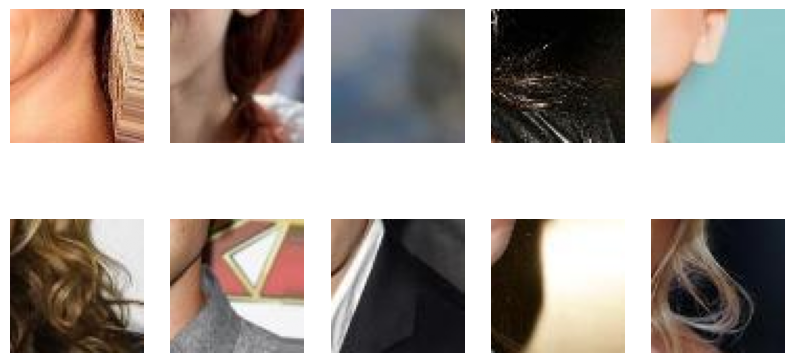

In [208]:
plt.figure(1, figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')

In [ ]:
dataset[0]

In [164]:
img_data = idg(
    rescale=1/255,
    dtype=tf.float32
)

In [187]:
dataset3 = img_data.flow_from_directory(
    'D:\\data sets\\celeb_a\\',
    target_size=(64, 64),
    class_mode='categorical'
)

Found 202599 images belonging to 1 classes.


In [217]:
#image reading and pre-processing
dataset2 = keras.utils.image_dataset_from_directory(
    data_dr,
    label_mode=None,
    image_size=(64, 64), 
    batch_size=32,
)

Found 202599 files belonging to 1 classes.


In [160]:
dataset3 = dataset2

tensorflow.python.data.ops.dataset_ops.MapDataset

In [60]:
dataset = dataset.map(lambda x: x/225)

In [40]:
gen = Sequential()

In [41]:
gen.add(Input(shape=(100, )))
gen.add(Dense(8*8*100))
gen.add(Reshape((8, 8, 100)))
gen.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
gen.add(LeakyReLU(alpha=0.2))
gen.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
gen.add(LeakyReLU(alpha=0.2))
gen.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
gen.add(LeakyReLU(alpha=0.2))
gen.add(Conv2DTranspose(3, kernel_size=5, padding='same', activation='sigmoid'))

In [ ]:
gen.summary()

In [42]:
discr = Sequential()
discr.add(Input(shape=(64, 64, 3)) )
discr.add(Conv2D(64, kernel_size=4, strides=2, padding='same'))
discr.add(LeakyReLU(alpha=0.2))
discr.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discr.add(LeakyReLU(alpha=0.2))
discr.add(Conv2D(64, kernel_size=4, strides=2, padding='same'))
discr.add(LeakyReLU(alpha=0.2))
discr.add(Flatten())
discr.add(Dropout(0.2))
discr.add(Dense(1, activation='sigmoid'))

In [43]:
gan = Sequential([gen, discr])
discr.compile(optimizer='adam', loss='binary_crossentropy')
discr.trainable=False

In [44]:
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
gan.summary()

In [213]:
#gan_1.fit(dataset, epochs=epochs)

In [190]:
epochs = 30
batch_size = 32
noise_shape = 100

In [133]:
len(dataset)
dataset[:batch_size].shape

(40, 64, 64, 3)

In [191]:
with tf.device('/gpu:0'):
    for epoch in range(epochs):
        print(f'Currently on epoch {epoch+1}')
        for i in range(len(dataset)):
            noise=np.random.normal(size=[batch_size, noise_shape])
            gen_img = gen.predict_on_batch(noise)
            
            #train discriminator on real
            train_label=np.ones(shape=[batch_size, 1])
            discr.trainable=True
            d_loss_real=discr.train_on_batch(dataset, train_label)
            
            #train discriminator on fake
            train_label=np.zeros(shape=(batch_size, 1))
            d_loss_fake=discr.train_on_batch(dataset, train_label)
            
            #train generator
            noise=np.random.normal(size=[batch_size, noise_shape])
            train_label=np.ones(shape(batch_size, 1))
            discr.trainable=False
            g_loss=gen.train_on_batch(noise, train_label)            

Currently on epoch 1


AttributeError: 'DirectoryIterator' object has no attribute 'shape'

In [37]:
fake_x.shape

(1, 64, 64, 3)

1/1 [==============================] - 0s 192ms/step


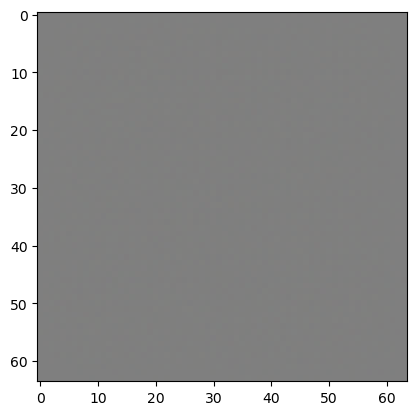

In [46]:
fake_x =gen.predict(np.random.normal(loc=0, scale=1, size=(1, 100)))
plt.imshow(fake_x.reshape(64, 64, 3))